# TFIP telegram chat analysis

<a id='100'></a>
#### Content
1. [Introduction](#1)
2. [Libraries](#2)
3. [Data Loading](#3)
4. [Data Cleaning](#4)
5. [Most Talked About Tracks](#5)
6. [Sentiment Analysis](#6)
7. [Interview Compilation](#7)
8. [End Noted and Future Opportunities](#8)

<a id='1'></a>
# [Introduction](#100)

TFIP is a program organized by IBF Singapore to train and upskill Singaporean workers in fintech roles. There are 10 tracks that applicants can choose to apply from (Artificial Intelligence, Cloud Computing, Cybersecurity, Data Analytics, Software Engineering, Technology Product Management, Business Analysis, Digital Marketing, Agile IT Project Management, User Experience Design. More information about the program can be found here: https://www.ibf.org.sg/programmes/Pages/TFIP.aspx

A telegram chat has been created for potential candidates to discuss about the program. In this project, I will be analyzing the discussions in the telegram chat focusing on 3 main areas:
1. What are the most talked about tracks
2. Sentiment analysis
3. Compiling the number of interviews and grouping them based on tracks and companies 

<a id='2'></a>
# [Libraries](#100)

In [1]:
import numpy as np
import pandas as pd
import json
import re

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt
from wordcloud import WordCloud

<a id='3'></a>
# [Data Loading](#100)

In [2]:
with open('result.json', encoding='utf-8') as json_file:
    data = json.load(json_file)
data = data['messages']

In [3]:
df = pd.DataFrame(data)

df.head()

,id,type,date,actor,actor_id,action,inviter,text,from,from_id,...,thumbnail,media_type,sticker_emoji,width,height,photo,mime_type,forwarded_from,duration_seconds,via_bot
0,-999985497,service,2021-09-12T09:32:36,Sydni Ng,user639243055,join_group_by_link,Group,,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-999985496,message,2021-09-12T09:33:02,NaN,NaN,NaN,NaN,Hello,jgyy,user887830468,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-999985495,message,2021-09-12T09:33:39,NaN,NaN,NaN,NaN,Hi! Sydni here,Sydni Ng,user639243055,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-999985494,message,2021-09-12T09:34:41,NaN,NaN,NaN,NaN,Hello!,Baz,user371628165,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-999985493,message,2021-09-12T09:34:51,NaN,NaN,NaN,NaN,Welcome to the group! It's small now but hopef...,Baz,user371628165,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<a id='4'></a>
# [Data cleaning](#100)

Drop rows that are 'service' under type column (non user messages)

In [4]:
df.drop(df[df.type == 'service'].index, inplace=True)

Keep the following columns: date, text, from_id

In [5]:
df = df[['date', 'text', 'from_id']]

Some text are in str type and some are in list type. Text with list type include links/bot commands/mentions sent by users (dictionary type) which are not needed. I will explode each list and drop rows that are dictionary type. 

In [6]:
df = df.explode('text')

df.drop(df[df.text.map(type) == dict].index, inplace=True)

Split text based on sentence

In [7]:
def split_text(text):
    split_text = []
    tokenize_sent = sent_tokenize(text)
    for sent in tokenize_sent:
        for s in sent.split('\n'):
            split_text.append(s)
    return split_text

In [8]:
df['split_sentence'] = df['text'].apply(split_text)

In [9]:
df = df.explode('split_sentence')

Create a new column for lower casing split_sentence

In [10]:
def lower_case(text):
    return str(text).lower()

In [11]:
df['split_sentence_lower'] = df['split_sentence'].apply(lower_case)

Drop null rows

In [12]:
df.dropna(inplace=True)

Cleaning and standardizing common terms

In [13]:
def clean_text(sent):
    tokenized_word = []
    sent = sent.lower()
    sent = re.sub('[^\w\s]', ' ', sent)
    
    sent = re.sub(r'software engineer', 'se ', sent)
    sent = re.sub(r'swe', 'se ', sent)
    sent = re.sub(r'business analysis', 'ba ', sent)
    sent = re.sub(r'agile', 'apm', sent)
    sent = re.sub(r'digital marketing', 'dm', sent)
    
    sent = re.sub(r'jp morgan', 'jp ', sent)
    sent = re.sub(r'jpm', 'jp ', sent)
    sent = re.sub(r'goldman', 'gs ', sent)
    sent = re.sub(r'singapore exchange', 'sgx ', sent)
    sent = re.sub(r'bank of singapore', 'bos', sent)
    sent = re.sub(r'bank of america', 'boa', sent)
    sent = re.sub(r'great eastern', 'ge', sent)
    sent = re.sub(r'hong leong', 'hl', sent)
    sent = re.sub(r'standchart', 'scb', sent) 
    
    for word in word_tokenize(sent):
        tokenized_word.append(word)
    return tokenized_word

In [14]:
df['cleaned_text'] = df['split_sentence'].apply(clean_text) 

In [15]:
df.head()

,date,text,from_id,split_sentence,split_sentence_lower,cleaned_text
1,2021-09-12T09:33:02,Hello,user887830468,Hello,hello,[hello]
2,2021-09-12T09:33:39,Hi! Sydni here,user639243055,Hi!,hi!,[hi]
2,2021-09-12T09:33:39,Hi! Sydni here,user639243055,Sydni here,sydni here,"[sydni, here]"
3,2021-09-12T09:34:41,Hello!,user371628165,Hello!,hello!,[hello]
4,2021-09-12T09:34:51,Welcome to the group! It's small now but hopef...,user371628165,Welcome to the group!,welcome to the group!,"[welcome, to, the, group]"


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20273 entries, 1 to 15537
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   date                  20273 non-null  object
 1   text                  20273 non-null  object
 2   from_id               20273 non-null  object
 3   split_sentence        20273 non-null  object
 4   split_sentence_lower  20273 non-null  object
 5   cleaned_text          20273 non-null  object
dtypes: object(6)
memory usage: 1.1+ MB


<a id='5'></a>
# [Most talked about tracks](#100)

#### Tracks
- Artificial Intelligence (ai)
- Cloud Computing (CC)
- Cybersecurity (CS)
- Data Analytics (DA)
- Software Engineering (SE)
- Technology Product Management (TPM)
- Business Analysis (BA)
- Digital Marketing (DM)
- Agile IT Project Management (APM)
- User Experience Design (UX)

Which is the most talked about tracks for TFIP 2021?

In [17]:
# for better visualization
conversion = {'ai': 'Artificial Intelligence', 
              'cc': 'Cloud Computing',
              'cs': 'Cybersecurity',
              'da': 'Data Analytics',
              'se': 'Software Engineering',
              'tpm': 'Technology Product Management',
              'ba': 'Business Analysis',
              'dm': 'Digital Marketing',
              'apm': 'Agile IT Project Management',
              'ux': 'User Experience Design'}

In [18]:
tracks_count = {}

for texts in df.cleaned_text:
    for text in texts:
        if text in conversion:
            if conversion[text] in tracks_count:
                tracks_count[conversion[text]] += 1
            else:
                tracks_count[conversion[text]] = 1
tracks_count

{'Software Engineering': 314,
 'Agile IT Project Management': 154,
 'Data Analytics': 316,
 'Artificial Intelligence': 188,
 'Cybersecurity': 117,
 'User Experience Design': 86,
 'Digital Marketing': 23,
 'Cloud Computing': 104,
 'Business Analysis': 181,
 'Technology Product Management': 28}

In [19]:
sorted_tracks = {key: value for key, value in sorted(tracks_count.items(), key=lambda item: item[1])}

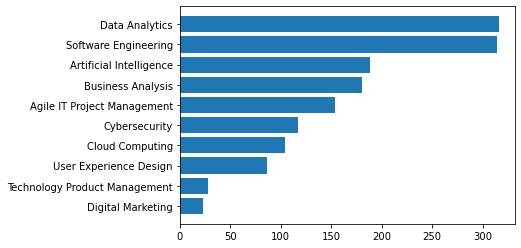

In [20]:
tracks = list(sorted_tracks.keys())
values = list(sorted_tracks.values())

plt.barh(range(len(sorted_tracks)), values, tick_label=tracks)
plt.show()

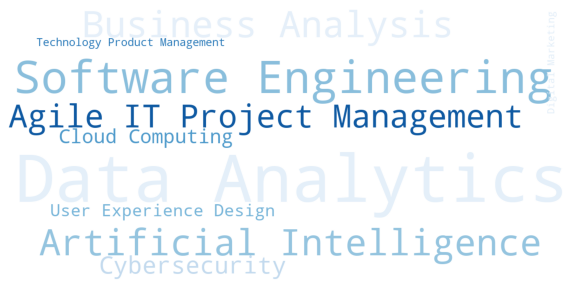

In [21]:
wordcloud = WordCloud(scale=3,
                      min_font_size=5, 
                      max_font_size=100, 
                      colormap='Blues',
                      background_color='white').generate_from_frequencies(tracks_count)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

<a id='6'></a>
# [Sentiment Analysis](#100)
How are the sentiments of the users as the days go by?

In [22]:
df1 = df.copy()

df1 = df1[['date', 'split_sentence']]

Get month and date

In [23]:
def get_date(date):
    return date[5:10]

In [24]:
df1['date_'] = df1['date'].apply(get_date)

Get sentiment score for each sentence

In [25]:
sentiment_analyzer = SentimentIntensityAnalyzer()

In [26]:
def get_polarity(text): 
    return sentiment_analyzer.polarity_scores(text)['compound']

In [27]:
df1['sentiment'] = df1['split_sentence'].apply(get_polarity)

Get average sentiment score per day

In [28]:
average_sentiments_by_day = df1.groupby('date_').mean()

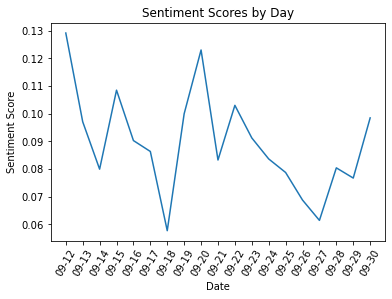

In [29]:
plt.plot(average_sentiments_by_day)
plt.xlabel('Date')
plt.xticks(rotation=60)
plt.ylabel('Sentiment Score')
plt.title('Sentiment Scores by Day')
plt.show()

The sentiments are generally on the low positive side. The days with higher sentiments are generally days with more users getting interview invitations.

<a id='7'></a>
# [Interview Compilation](#100)

There are many users who are curious to know if there are users getting interviews for different tracks and different companies. However, the chat messages are moving too fast for users to keep track of what others mentioned. So I will attempt to compile the number of interviews from different users into a chart sorted by tracks and companies. 

There are 2 approaches to this analysis:
1. Do data labelling for the messages. Positive for messages that says have interview and negative for messages that doesn't have interview and apply machine learning models to predict whether each message is positive or negative. Followed by sorting the positive messages by tracks and companies.<br>
<br>
2. Identify each positive sentence by 3 components:
    - having the word 'interview', 'call', 'email'
    - stating the track
    - stating the company

<br>
I have decided to go with approach #2 because data labelling requires a lot of time resource and the % of positive interview messages is very low. There are a lot of discussions going on and not just users stating whether they have an interview or not.
<br> 
<br>
Approach #2 is a more straight forward approach. However, some things needs to be taken into consideration. There are messages with all 3 components but are in a form of question and not a statement. Eg: 'Did anyone receive interview for cs from dbs?' VS 'I received and interview for cs with dbs'. Second, there might be users who replied multiple times to different users, saying the same interview message but it should only be counted as 1.

So the steps to this approach would be: 
    -  to filter away sentences that are questions
    -  keep sentences that includes 'interview', 'call', 'email'
    -  sort the messages by users and count the unique track/company per user

##### Filtering sentences that are questions

In [30]:
# extracted from: https://stackoverflow.com/questions/49100615/nltk-detecting-whether-a-sentence-is-interogative-or-not

posts = nltk.corpus.nps_chat.xml_posts()[:10000]

def dialogue_act_features(post):
    features = {}
    for word in nltk.word_tokenize(post):
        features['contains({})'.format(word.lower())] = True
    return features

featuresets = [(dialogue_act_features(post.text), post.get('class')) for post in posts]

# 10% of the total data
size = int(len(featuresets) * 0.1)

# first 10% for test_set to check the accuracy, and rest 90% after the first 10% for training
train_set, test_set = featuresets[size:], featuresets[:size]

# get the classifer from the training set
classifier = nltk.NaiveBayesClassifier.train(train_set)
# to check the accuracy - 0.67
# print(nltk.classify.accuracy(classifier, test_set))

question_types = ["whQuestion","ynQuestion"]
def is_ques_using_nltk(ques):
    question_type = classifier.classify(dialogue_act_features(ques)) 
    return question_type in question_types

question_pattern = ["do i", "do you", "what", "who", "is it", "why","would you", "how","is there",
                    "are there", "is it so", "is this true" ,"to know", "is that true", "are we", 
                    "am i", "question is", "tell me more", "can i", "can we", "tell me", 
                    "can you explain", "question","answer", "questions", "answers", "ask"]

helping_verbs = ["is","am","can", "are", "do", "does"]
# check with custom pipeline if still this is a question mark it as a question
def is_question(question):
    question = question.lower().strip()
    if not is_ques_using_nltk(question):
        is_ques = False
        # check if any of pattern exist in sentence
        for pattern in question_pattern:
            is_ques = pattern in question
            if is_ques:
                break

        # there could be multiple sentences so divide the sentence
        sentence_arr = question.split(".")
        for sentence in sentence_arr:
            if len(sentence.strip()):
                # if question ends with ? or start with any helping verb
                # word_tokenize will strip by default
                first_word = nltk.word_tokenize(sentence)[0]
                if sentence.endswith("?") or first_word in helping_verbs:
                    is_ques = True
                    break
        return is_ques    
    else:
        return True

In [31]:
df2 = df.copy()
df2.reset_index(inplace=True)
df2.drop(['index'], axis=1, inplace=True)

In [32]:
df2.drop(df2[df2.split_sentence.map(is_question) == True].index, inplace=True)

##### Keep sentences that includes 'interview', 'call', 'email'

In [33]:
def filter_words(text):
    if 'interview' in text or 'call' in text or 'email' in text:
        return True
    return False

In [34]:
df2.drop(df2[df2.split_sentence_lower.map(filter_words) == False].index, inplace=True)

##### Sort the messages by users and count the unique track/company per user

In [35]:
# check if each sentence has got the following words
tracks = ['ai', 'cc', 'cs', 'da', 'se', 'tpm', 'ba', 'dm', 'apm', 'ux']
companies = ['aia', 'boa', 'bos', 'barclays', 'bearingpoint', 'bnp', 'citi', 'credit', 'dbs', 
             'deutsche', 'dymon', 'ecics', 'ge', 'gs', 'hl', 'boc', 'jp', 'lgt', 'maybank', 
             'mizuho', 'mlp', 'msig', 'mufg', 'ntuc', 'ocbc', 'partners', 'philip', 'point72', 
             'prudential', 'scb', 'schroder', 'sgx', 'sumitomo', 'uob', 'ubs', 'youtrip']

filter_tracks_companies = [] 

for sent in df2['cleaned_text']:
    t = []
    c = []
    for word in sent:
        if word in tracks:
            t.append(word)
        if word in companies:
            c.append(word)
    if len(t) > 0 and len(c) > 0:
        t, c = set(t), set(c)
        filter_tracks_companies.append([t,c])

print(filter_tracks_companies)

[[{'cs'}, {'sgx'}], [{'se'}, {'ubs'}], [{'se'}, {'ubs'}], [{'cs'}, {'jp'}], [{'se'}, {'aia', 'msig'}], [{'se'}, {'dbs'}], [{'ai'}, {'ocbc'}], [{'cs'}, {'ubs'}], [{'cs', 'apm'}, {'uob'}], [{'se'}, {'prudential'}], [{'apm'}, {'uob'}], [{'se'}, {'barclays'}], [{'da'}, {'gs'}], [{'se'}, {'barclays'}], [{'cs', 'apm'}, {'ge', 'uob'}], [{'se'}, {'ubs'}], [{'apm'}, {'ubs'}], [{'se'}, {'prudential'}], [{'se'}, {'ubs'}], [{'se', 'cc'}, {'ubs'}], [{'dm'}, {'dbs'}], [{'se'}, {'ubs'}], [{'cc'}, {'boa'}], [{'cs'}, {'dbs'}], [{'se'}, {'partners'}], [{'ai'}, {'ubs'}], [{'da'}, {'ubs'}], [{'se'}, {'dbs'}], [{'apm'}, {'dbs', 'ubs'}], [{'cs'}, {'dbs'}], [{'cc'}, {'dbs'}], [{'apm'}, {'dbs'}], [{'apm', 'cs'}, {'dbs'}], [{'se'}, {'dbs'}], [{'apm'}, {'dbs'}], [{'se'}, {'dbs'}], [{'da'}, {'dbs'}], [{'se'}, {'ubs'}], [{'da'}, {'gs'}], [{'ba'}, {'uob'}], [{'apm'}, {'dbs'}], [{'apm'}, {'barclays'}], [{'da'}, {'dbs'}], [{'se'}, {'ubs'}], [{'se'}, {'ubs'}], [{'apm'}, {'dbs'}], [{'ai'}, {'uob'}], [{'cs'}, {'sgx'}],

There are some users with interviews with multiple tracks per company or multiple companies per track. Split them up into track/company combinations

In [36]:
interviews = []

for lst in filter_tracks_companies:
    for l in lst[0]:
        for m in lst[1]:
            interviews.append([l,m])

print(interviews)
print(len(interviews))

[['cs', 'sgx'], ['se', 'ubs'], ['se', 'ubs'], ['cs', 'jp'], ['se', 'aia'], ['se', 'msig'], ['se', 'dbs'], ['ai', 'ocbc'], ['cs', 'ubs'], ['cs', 'uob'], ['apm', 'uob'], ['se', 'prudential'], ['apm', 'uob'], ['se', 'barclays'], ['da', 'gs'], ['se', 'barclays'], ['cs', 'ge'], ['cs', 'uob'], ['apm', 'ge'], ['apm', 'uob'], ['se', 'ubs'], ['apm', 'ubs'], ['se', 'prudential'], ['se', 'ubs'], ['se', 'ubs'], ['cc', 'ubs'], ['dm', 'dbs'], ['se', 'ubs'], ['cc', 'boa'], ['cs', 'dbs'], ['se', 'partners'], ['ai', 'ubs'], ['da', 'ubs'], ['se', 'dbs'], ['apm', 'dbs'], ['apm', 'ubs'], ['cs', 'dbs'], ['cc', 'dbs'], ['apm', 'dbs'], ['apm', 'dbs'], ['cs', 'dbs'], ['se', 'dbs'], ['apm', 'dbs'], ['se', 'dbs'], ['da', 'dbs'], ['se', 'ubs'], ['da', 'gs'], ['ba', 'uob'], ['apm', 'dbs'], ['apm', 'barclays'], ['da', 'dbs'], ['se', 'ubs'], ['se', 'ubs'], ['apm', 'dbs'], ['ai', 'uob'], ['cs', 'sgx'], ['da', 'ubs'], ['cc', 'boa'], ['cc', 'dbs'], ['cc', 'ubs'], ['se', 'dbs'], ['da', 'dbs'], ['se', 'lgt'], ['se', 'ai

In [37]:
# creating empty dataframe
compiled_df2 = pd.DataFrame(0, index=companies, columns=tracks)

# adding values to corresponding row/columns
for interview in interviews:
    compiled_df2[interview[0]][interview[1]] += 1

# renaming column headers 
compiled_df2.rename(columns={'ai': 'AI', 'cc': 'CC', 'cs': 'CS', 'da': 'DA', 'se': 'SE',
                            'tpm': 'TPM', 'ba': 'BA', 'dm': 'DM', 'apm': 'APM',
                            'ux': 'UX'}, inplace=True)

# renaming row headers
compiled_df2.rename(index={'aia': 'AIA', 'boa': 'Bank of America', 'bos': 'Bank of Singapore', 
                          'barclays': 'Barclays', 'bearingpoint': 'BearingPoint', 
                          'bnp': 'BNP Paribas', 'citi': 'Citibank N.A.', 'credit': 'Credit Suisse', 
                          'dbs': 'DBS Bank Ltd', 'deutsche': 'Deutsche Bank', 
                          'dymon': 'Dymon Asia', 'ecics': 'ECICS', 'ge': 'Great Eastern', 
                          'gs': 'Goldman Sachs', 'hl': 'Hong Leong Finance', 
                          'boc': 'Industrial and Commercial Bank of China', 'jp': 'JP Morgan', 
                          'lgt': 'LGT Bank', 'maybank': 'Maybank', 'mizuho': 'Mizuho Bank', 
                          'mlp': 'MLP', 'msig': 'MSIG', 'mufg': 'MUFG', 'ntuc': 'NTUC Income', 
                          'ocbc': 'Oversea-Chinese Banking Corporation Limited', 
                          'partners': 'Partners Group', 'philip': 'Philip Securities', 
                          'point72': 'Point72', 'prudential': 'Prudential', 
                          'scb': 'Standard Chartered Bank', 'schroder': 'Schroder Asset Management', 
                          'sgx': 'Singapore Exchange', 
                          'sumitomo': 'Sumitomo Mitsui Banking Corporation', 
                          'uob': 'United Overseas Bank Limited', 'ubs': 'UBS', 
                          'youtrip': 'YouTrip'}, inplace=True)

# adding total column and row
compiled_df2.loc[:,'Total'] = compiled_df2.sum(axis=1)
compiled_df2.loc['Total']= compiled_df2.sum(axis=0)

compiled_df2

,AI,CC,CS,DA,SE,TPM,BA,DM,APM,UX,Total
AIA,0,0,0,0,3,0,0,0,0,0,3
Bank of America,0,2,0,0,0,0,0,0,0,0,2
Bank of Singapore,0,0,0,0,0,0,0,0,0,0,0
Barclays,0,0,0,0,2,0,0,0,1,0,3
BearingPoint,0,0,0,0,0,0,1,0,0,0,1
BNP Paribas,0,0,1,0,0,0,0,0,0,0,1
Citibank N.A.,0,0,0,0,0,0,0,0,0,0,0
Credit Suisse,0,0,0,0,0,0,0,0,0,0,0
DBS Bank Ltd,0,3,3,3,8,0,0,2,7,0,26
Deutsche Bank,0,0,1,0,0,0,0,0,0,0,1


This segment provides a very brief idea of how many interviews are being scheduled with users for each track and company based on telegram chats. It requires users to explicitly states that they have interviews with certain companies for certain tracks for the data to be captured. There are no doubt shortfalls to this model. Some data are inaccurately captured while others are not being captured. I am also unable to use ML model (approach #1 as discussed above) due to constrains. I will need input data and outcome to generate the rules of deciding whether an user has got an interview or not for ML to work.

<a id='8'></a>
# [End Notes and Future Opportunities](#100)

Although there are shortfalls that I would like to address but given the time and knowledge constrain, I am still quite satisfied with what I have achieved in < 2 weeks of my basic NLP learning journey. It has given me a glimpse of what I can achieve with NLP in the future. Next up, will be to strengthen my deep learning skills and knowledge and to explore useful libraries/tools. I hope to be able to use more ML models for my next NLP project.

Lastly, good luck to all potential candidates for TFIP 2021! 